## haMSM for Eg5-ADP WT Unbinding WE Simulation Data
---
Using pairwise distances of ADP (370) to Eg5 Loop 5 (116-133) for featurization.

Here, testing out a sigmoidal distance matrix smoothing function:

$f(x) = 1 - \frac{1}{1 + \exp\frac{-(x-5.0)}{0.75}}$

Inspired from: Widmer *et al.*, *J. Chem. Phys.* (2023), equation 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm.auto

In [2]:
pwd

'/ix/lchong/dty7/eg5/h2p-we/multi-mab_wmon_v00/haMSM'

In [3]:
from msm_we import msm_we
import mdtraj as md

In [4]:
import ray
ray.init(num_cpus=8)
#ray.init()

2024-02-26 17:30:26,473	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8265


In [5]:
#ray.shutdown()

Model Name

In [6]:
model_name = 'Eg5_MON_ADP_CA_L5_116-133_sigmoid'

In [7]:
import logging
from rich.logging import RichHandler
#logging.basicConfig(filename="msm_we.log", encoding="utf-8", level=logging.DEBUG)
log = logging.getLogger()
log.addHandler(RichHandler())

msm_log = logging.getLogger("msm_we.msm_we")

In [8]:
def processCoordinates(self, coords):
    log.debug("Processing coordinates")

    if self.dimReduceMethod == "none":
        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        indAlign = self.reference_structure.topology.select("name CA")
        x2 = xt.superpose(self.reference_structure,atom_indices=indAlign)
        coords = x2._xyz.astype('float64')
        nA = np.shape(indCA)[0]
        nC = np.shape(coords)[0]
        new_coords = coords[:,tuple(indCA),:]
        #new_coords = numpy.double(new_coords)
        #new_coords = coords[:, :923, :]
        data = new_coords.reshape(nC, 3 * nA)
        model.nAtoms = nA
        return data

    if self.dimReduceMethod == "pca" or self.dimReduceMethod == "vamp":

        # Dimensionality reduction
        
        xt = md.Trajectory(xyz=coords, topology=None)
        # ADP heavy atoms
        indADP = self.reference_structure.topology.select("not type H and resid 370")
        # CA atoms of loop 5
        indCA = self.reference_structure.topology.select("name CA and resid 116 to 133")
        # CA atoms of Eg5 (non-flexible termini)
        #indCA = self.reference_structure.topology.select("name CA and resid 18 to 364")
        # calc distance matrix
        pair1, pair2 = np.meshgrid(indADP, indCA, indexing="xy")
        
        ### for 2D distance matrices ###
        #pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        #indUT = np.where(np.triu(pair1, k=1) > 0)
        #pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        #dist = md.compute_distances(xt, pairs, periodic=True, opt=True)
        
        ### special for 1D distance matrix of ADP-Eg5 ###
        # make pair array
        pairs = np.array((pair1, pair2))
        # reduce dim to 2
        pairs = pairs.squeeze()
        # convert to shape (n_pairs, 2) where row items are the atom index pair vals
        pairs = np.rot90(pairs, k=-1)
        indUT = np.where(np.triu(pair1, k=1) > 0)
        pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

        return dist

# Monkey-patch, i.e. replace the placeholder processCoordinates method in msm_we.modelWE
msm_we.modelWE.processCoordinates = processCoordinates

Testing different `processCoordinates` code. Needs to be adjusted to handle non-2D distance matrix type data.

In [66]:
xt = md.load("1x88_dry.pdb", top="1x88_dry.pdb")
# xt = md.Trajectory(xyz=coords, topology=None)
# ADP heavy atoms
indADP = xt.topology.select("not type H and resid 370")
# CA atoms of Eg5 (non-flexible termini)
indCA = xt.topology.select("name CA and resid 18 to 364")

pair1, pair2 = np.meshgrid(indADP, indCA, indexing="xy")
# pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")

# make pair array
pairs = np.array((pair1, pair2))
# reduce dim to 2
pairs = pairs.squeeze()
# convert to shape (n_pairs, 2) where row items are the atom index pair vals
pairs = np.rot90(pairs, k=-1)
indUT = np.where(np.triu(pair1, k=1) > 0)
pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

Applying sigmoidal transform:

Trying it with 10A cutoff since using ADP to L5 distances.

In [9]:
def sigmoidal(x, cutoff=10):
    """
    $f(x) = 1 - \frac{1}{1 + \exp\frac{-(x-cutoff)}{0.75}}$
    
    Parameters
    ----------
    x : input float
    
    Returns
    -------
    f(x) : sigmoidal function transformed float
    """
    return 1 - (1 / (1 + np.exp(-(x - cutoff) / 0.75)))

In [10]:
# vectorize sigmoid function to apply to entire dmat
# this should work to apply to multi-dimensional arrays
vf = np.vectorize(sigmoidal)

In [11]:
def processCoordinates(self, coords):
    log.debug("Processing coordinates")

    if self.dimReduceMethod == "none":
        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        indAlign = self.reference_structure.topology.select("name CA")
        x2 = xt.superpose(self.reference_structure,atom_indices=indAlign)
        coords = x2._xyz.astype('float64')
        nA = np.shape(indCA)[0]
        nC = np.shape(coords)[0]
        new_coords = coords[:,tuple(indCA),:]
        #new_coords = numpy.double(new_coords)
        #new_coords = coords[:, :923, :]
        data = new_coords.reshape(nC, 3 * nA)
        model.nAtoms = nA
        return data

    if self.dimReduceMethod == "pca" or self.dimReduceMethod == "vamp":

        # Dimensionality reduction
        
        xt = md.Trajectory(xyz=coords, topology=None)
        # ADP heavy atoms
        indADP = self.reference_structure.topology.select("not type H and resid 370")
        # CA atoms of loop 5
        indCA = self.reference_structure.topology.select("name CA and resid 116 to 133")
        # CA atoms of Eg5 (non-flexible termini)
        #indCA = self.reference_structure.topology.select("name CA and resid 18 to 364")
        # calc distance matrix
        pair1, pair2 = np.meshgrid(indADP, indCA, indexing="xy")
        
        ### for 2D distance matrices ###
        #pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        #indUT = np.where(np.triu(pair1, k=1) > 0)
        #pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        #dist = md.compute_distances(xt, pairs, periodic=True, opt=True)
        
        ### special for 1D distance matrix of ADP-Eg5 ###
        # make pair array
        pairs = np.array((pair1, pair2))
        # reduce dim to 2
        pairs = pairs.squeeze()
        pairs = pairs.squeeze()
        log.info("PAIRS NDIM: ", pairs.ndim)
        log.info("pairs")
        # convert to shape (n_pairs, 2) where row items are the atom index pair vals
        pairs = np.rot90(pairs, k=-1)
        indUT = np.where(np.triu(pair1, k=1) > 0)
        pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

        return vf(dist)

# Monkey-patch, i.e. replace the placeholder processCoordinates method in msm_we.modelWE
msm_we.modelWE.processCoordinates = processCoordinates

### Building block-wise haMSM
---

In [12]:
cat ../tstate.file

unbound 12 1 6.1 6.1


Create the model object and initialize it

In [13]:
model =  msm_we.modelWE()
model.initialize(
    fileSpecifier=['west.h5'], 
    refPDBfile = '1x88_dry.pdb',
    modelName = model_name,
    basis_pcoord_bounds  = [[0,10], [100,np.inf], [0,6], [0,6]],
    target_pcoord_bounds = [[12,np.inf], [-np.inf,100], [6,np.inf], [6,np.inf]],
    dim_reduce_method = 'pca',
    tau = 50e-12,
    pcoord_ndim = 4,
)

Load all coords and pcoords up to the last iteration you want to use for analysis with

In [14]:
model.get_iterations()
# use up to n last_iter iterations
model.get_coordSet(last_iter=420, streaming=True)

Output()

Prepare dimensionality reduction transformer by running

In [15]:
model.dimReduce()

Output()

In [9]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_postPCA.pickle', 'rb') as f:
    model = load(f)

In [16]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_postPCA.pickle', 'wb') as f:
    dump(model, f)

Get WE bin mapper for cluster stratification (using updated bins, no 35 partition in pcoord 0)

In [17]:
import westpa
from westpa.core.binning import RectilinearBinMapper

# 1) ADP-Mg RMSD
# 2) ADP-Mg and Eg5 IntEne
# 3) ADP and Eg5 min dist
# 4) ADP-PO4 and Eg5 min dist
new_mapper = RectilinearBinMapper([[0, 5, 7, 9, 11, 13, 15, 
                                    17, 19, 22, 26, 30, np.inf],
                                   [-np.inf, -125, -75, -25, 
                                    25, 75, 125, 175, 225, 275, np.inf],
                                   [0, 3, 6, np.inf],
                                   [0, 6, np.inf],
                                  ])

Cluster and store original clustering

In [18]:
model.cluster_coordinates(n_clusters = 10, 
                          stratified = True,
                          tol = 1e-5, 
                          streaming = True, 
                          use_ray = True, 
                          first_cluster_iter = 100,
                          user_bin_mapper = new_mapper, 
                          store_validation_model = True)

[02/26/24 17:36:46] INFO     Be aware: Number of cluster centers is an important parameter, and  ]8;id=742932;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=922792;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#160\160]8;;\
                             can drastically affect model quality. We recommend examining                          
                             block-validation results with a range of numbers of clusters, to                      
                             check for overfitting.                                                                

                    INFO     Loading user-specified bin mapper for stratified clustering.        ]8;id=202307;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=641577;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#585\585]8;;\

                    INFO     Doing stratified clustering with 7200 total clusters       ]8;id=189686;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/stratified_clustering.py\stratified_clustering.py]8;;\:]8;id=379519;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/stratified_clustering.py#66\66]8;;\

Output()

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounds = np.array(bin_mapper.boundaries)
/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1380: RuntimeWarning: invalid value encountered in add
  _centers.append(dim[:-1] + (dim[1:] - dim[:-1]) / 2)
/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1373: RuntimeWarning: invalid value encountered in subtract
  return np.sqrt(np.mean(np.power(point - _centers, 2), axis=1))


In [14]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_4Dmap.pickle', 'rb') as f:
#with open('test_570-580_4Dmap.pickle', 'rb') as f:
    model = load(f)

In [19]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_4Dmap.pickle', 'wb') as f:
#with open('test_570-580_4Dmap.pickle', 'wb') as f:
    dump(model, f)

In [20]:
model.n_clusters

7200

Create the flux matrix with

In [21]:
model.get_fluxMatrix(n_lag=0, first_iter=100, last_iter=420, use_ray=True)

Output()

In [22]:
model.fluxMatrix

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_4Dmap_postfluxget.pickle', 'rb') as f:
    model = load(f)

In [23]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_4Dmap_postfluxget.pickle', 'wb') as f:
    dump(model, f)

Clean disconnected states and sort the flux matrix with

In [24]:
# optionally could adjust this cluster class attribute for pcoord sorting selection (default=0)
#model.pcoord_to_use = 0

In [25]:
model.organize_fluxMatrix(use_ray=True)

[02/26/24 17:52:42] INFO     Started with 7200 clusters, and removed 6271                       ]8;id=188352;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=670141;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=71716;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=412257;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 79, 81, 82, 83, 85, 87, 88, 89, 91, 92, 93, 94,                       
                             95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                      
                             109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,                      
                             122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135,                      
                             136, 137, 139, 141, 142, 143, 145, 147, 148, 149, 151, 153, 154,                      
                             155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,                      
                             168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,                      
                             181, 182, 183, 184, 185, 187, 189, 190, 191, 193, 195, 196, 197,                      
                             202, 203, 208, 209, 211, 213, 214, 215, 217, 218, 219, 220, 221,                      
                             223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 235, 236, 237,                      
                             238, 239, 241, 243, 244, 245, 247, 249, 250, 251, 253, 256, 257,                      
                             259, 262, 263, 265, 268, 269, 271, 272, 273, 274, 275, 277, 278,                      
                             279, 280, 281, 283, 284, 285, 286, 287, 289, 290, 291, 292, 293,                      
                             295, 296, 297, 298, 299, 301, 303, 304, 305, 307, 309, 310, 311,                      
                             313, 316, 317, 319, 322, 323, 324, 325, 328, 329, 330, 331, 332,                      
                             333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,                      
                             346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,                      
                             359, 361, 363, 364, 365, 367, 369, 370, 371, 373, 376, 377, 379,                      
                             382, 383, 384, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396,                      
                             397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,                      
                             410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 421, 423, 424,                      
                             425, 427, 429, 430, 431, 433, 436, 437, 439, 442, 443, 444, 445,                      
                             448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,                      
                             461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,                      
                             474, 475, 476, 477, 478, 479, 480, 481, 483, 484, 485, 487, 489,                      
                             490, 491, 493, 496, 497, 499, 502, 503, 504, 505, 508, 509, 510,                      
                             511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523,                      
                             524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536,             

Output()

Output()

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1632: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]


[02/26/24 18:08:21] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=539580;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=911978;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

In [26]:
model.fluxMatrix

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [8.73161993e-059, 1.14700036e-077, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 4.74276092e-042, ...,
        0.00000000e+000, 4.55298261e-040, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.06676211e-111, 0.00000000e+000, 2.38351353e-096],
       [0.00000000e+000, 0.00000000e+000, 4.35391876e-041, ...,
        0.00000000e+000, 9.99999963e-001, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 5.97294277e-053]])

In [7]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_4Dmap_postfluxorg.pickle', 'rb') as f:
    model = load(f)

In [27]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_4Dmap_postfluxorg.pickle', 'wb') as f:
    dump(model, f)

### Begin Model Analysis
---

Normalize the flux matrix to produce a transition matrix with

In [28]:
model.get_Tmatrix()

In [29]:
model.Tmatrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.71436961e-01, 1.14473433e-19, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.43552782e-03, ...,
        0.00000000e+00, 2.33807185e-01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.47558657e-16, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.35391887e-41, ...,
        0.00000000e+00, 9.99999989e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

Obtain steady-state distribution with

In [30]:
model.get_steady_state()

[02/26/24 18:08:24] INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=738472;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=646485;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#238\238]8;;\
                             with matrix power method.                                                             

                    WARNING  Power method did NOT obtain semidefinite pSS. Some negative values    ]8;id=622107;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=788002;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#256\256]8;;\
                             remain. This is weird, and you should try to figure out why this is                   
                             happening.                                                                            

                    WARNING  Some negative  elements in pSS... Ignoring, and setting model.pSS     ]8;id=4411;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=609139;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#276\276]8;;\
                             anyways.                                                                              

[02/26/24 18:08:25] INFO                                                                           ]8;id=284815;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=904142;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 1.2358e-28 after 4 iterations of inverse iteration.                 

(array([], dtype=int64),)


In [31]:
model.update_cluster_structures()

In [32]:
model.get_steady_state_target_flux()

print(f'Steady-state target rate is {model.JtargetSS:.2e}')

Steady-state target rate is 1.24e-28


In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_4Dmap_postsstflux.pickle', 'rb') as f:
    model = load(f)

In [33]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_4Dmap_postsstflux.pickle', 'wb') as f:
    dump(model, f)

### Begin Model Validation
---

In [34]:
# shape: clusters, pcoords, min/max
model.targetRMSD_minmax.shape

(931, 4, 2)

In [35]:
# For checking just in case your bins are not good.
array = model.targetRMSD_minmax[:,0,:]
print(array[23],array[50],array[132],array[142],array[148],array[151])

[6.4262085 6.9828949] [7.00209045 8.98899841] [ 9.00540161 10.97470093] [ 9.07240295 10.77949524] [ 9.17350769 10.85211182] [ 9.3006897 10.9513092]


In [36]:
# one issue here: each pcoord dim is the same values as pcoord 0 
# (TODO: update code for grabbing all pcoords)
model.targetRMSD_minmax[0]

array([[  5.623703  ,   6.98970032],
       [-14.3835907 ,  24.24771118],
       [  1.57070923,   2.99481201],
       [  2.95550537,   4.710495  ]])

In [37]:
model.targetRMSD_minmax[:,0,:].shape

(931, 2)

In [38]:
def plot_clusters(pcoord_to_use=0, ax=None):
    """
    MSM Bin coverage plot with sorting based on specified pcoord.
    """
    # sort by pcoord n
    model.pcoord_to_use = pcoord_to_use
    model.get_cluster_centers()
    #model.update_sorted_cluster_centers()

    # isolate pcoord min max array
    array = model.targetRMSD_minmax[:,pcoord_to_use,:]

    # set up plot objects
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    else:
        fig = plt.gcf()
    
    # len-2 because the last two are NaN (eq simulation; target/basis states)
    for idx in range(0,len(array)):
        ax.errorbar(array[idx,0], idx,xerr=[[0],[array[idx,1]-array[idx,0]]])
        #ax.plot(idx, array[idx,1], 'ro')
    ax.set_ylabel('cluster number')
    ax.set_xlabel(f'Pcoord {pcoord_to_use}')
    ax.set_title('MSM Bins Coverage')

/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


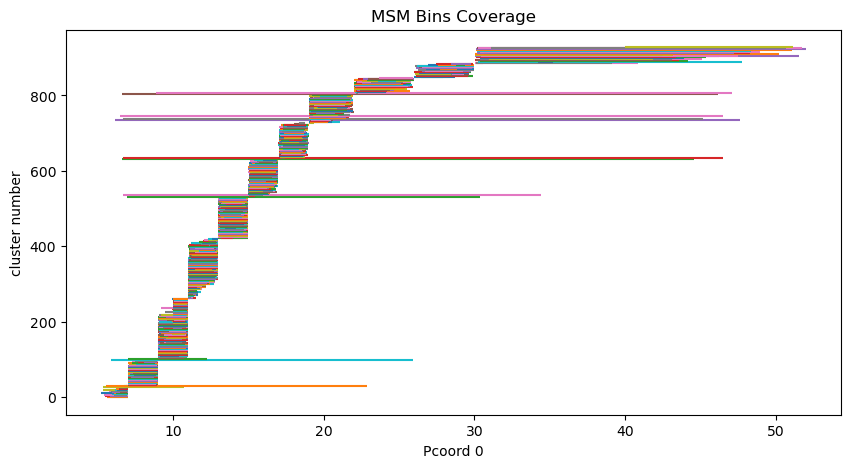

In [39]:
plot_clusters(0)

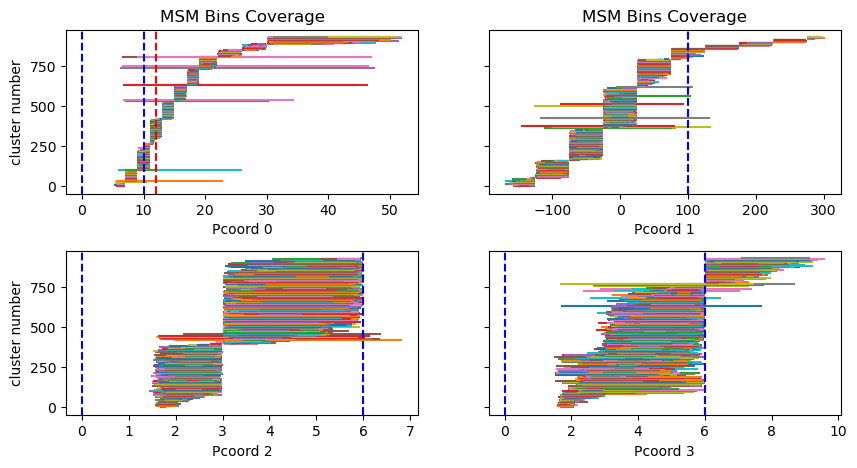

In [40]:
# making a 4 panel plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    plot_clusters(i, panel)
    model.draw_basis_target_boundaries(panel, i)
ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")
ax[1,0].set_title("")
ax[1,1].set_title("")
plt.subplots_adjust(hspace=0.35)

Had to adjust `_plotting.py` before `plot_flux` worked:
``` Python
322             binCenters[_model.indTargets] = _model.target_bin_centers[pcoord_to_use]
323             binCenters[_model.indBasis] = _model.basis_bin_centers[pcoord_to_use]
```

[02/26/24 18:11:47] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=482091;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=685069;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    INFO     Fluxes have not yet been generated for main_model, generating now.    ]8;id=758017;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=702392;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#311\311]8;;\

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=918338;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=355766;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#403\403]8;;\
                             currently built in to the code.                                                       

<Axes: xlabel='Pcoord 1', ylabel='Flux (weight/second)'>

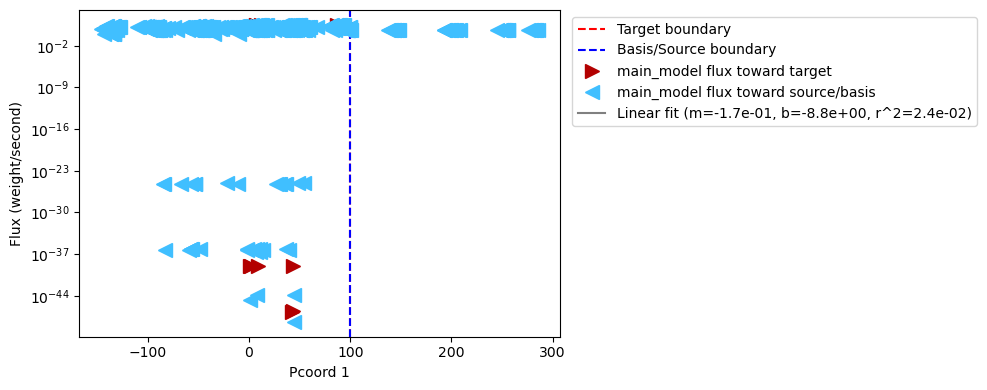

In [41]:
model.plot_flux(suppress_validation=True, pcoord_to_use=1)

[02/26/24 18:12:22] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=745639;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=722134;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=650170;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=266537;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=23925;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=156901;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=746984;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=653128;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

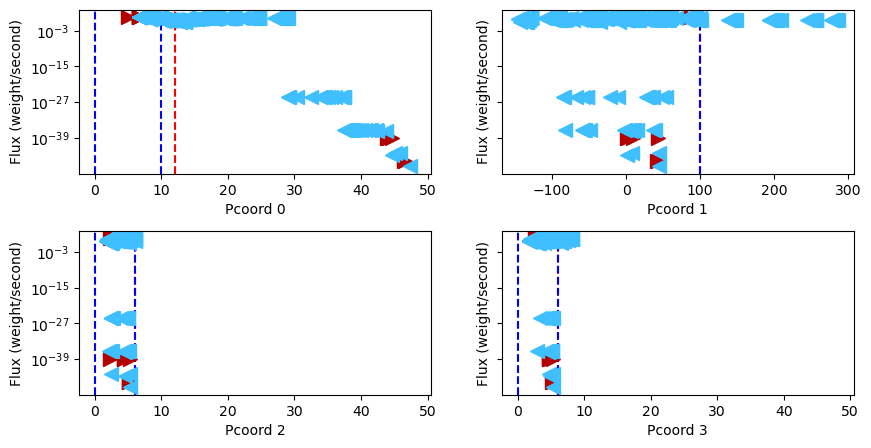

In [42]:
# making a 4 panel flux vs pcoord plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    model.plot_flux(suppress_validation=True, pcoord_to_use=i, ax=panel)
    
plt.subplots_adjust(hspace=0.35)

In [43]:
model.get_committor()

                    INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=782517;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=197820;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

  0%|          | 0/5.0 [00:00<?, ?it/s]

In [44]:
# optionally could adjust this cluster class attribute for pcoord to use (default=0)
model.pcoord_to_use = 0

[02/26/24 18:12:29] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=104348;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=22040;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

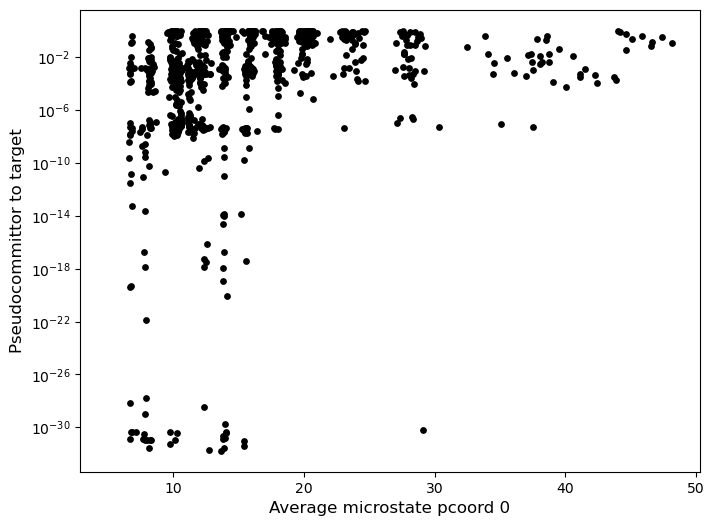

In [45]:
model.plot_committor()

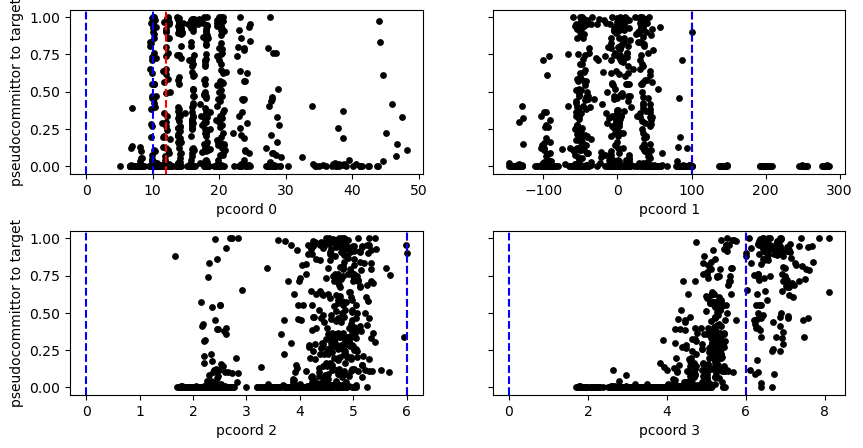

In [46]:
# making a 4 panel committor plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    panel.scatter(model.targetRMSD_centers[:,i], model.q, s=15, c='k')
    panel.set_xlabel(f"pcoord {i}")
    model.draw_basis_target_boundaries(panel, i)
ax[0,0].set_ylabel("pseudocommittor to target")
ax[1,0].set_ylabel("pseudocommittor to target")
fig.subplots_adjust(hspace=0.35)
#plt.yscale('log')

In [47]:
# first 3 center datapoints using all pcoord dims
model.targetRMSD_centers[:3,:]

array([[ 11.20780087, 278.42999268,   1.7033    ,   1.7033    ],
       [ 10.3108989 , 282.2684288 ,   1.73548672,   1.73548672],
       [ 11.21355009, 276.03604126,   1.74249911,   1.74249911]])

In [48]:
# q is committor array per cluster
model.q.shape

(931,)

[02/26/24 18:12:31] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=242076;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=846333;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#118\118]8;;\
                             plots.                                                                                

                    INFO     Committor-fluxes have not yet been generated for main_model,          ]8;id=921998;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=63673;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#153\153]8;;\
                             generating now.                                                                       

Obtaining pseudocommittor-fluxes:   0%|          | 0/930 [00:00<?, ?it/s]

[02/26/24 18:13:04] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=711096;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=576878;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

<Axes: xlabel='Pseudocommittor', ylabel='Flux (weight/second)'>

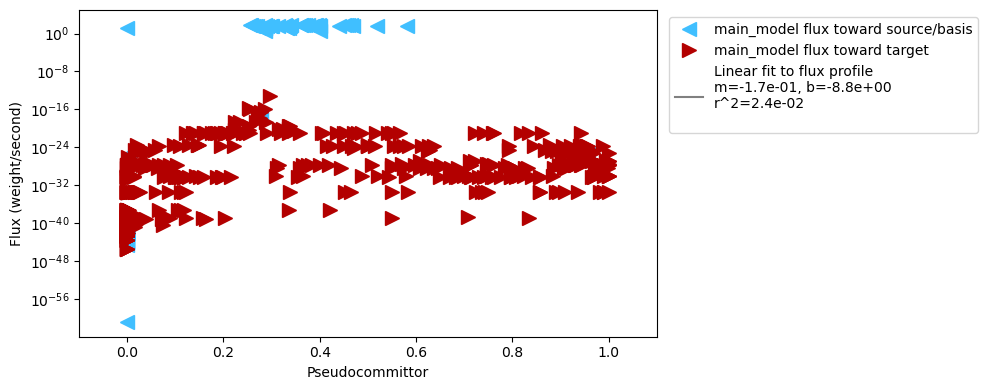

In [49]:
model.plot_flux_committor(suppress_validation=True)
#plt.gca().set_yscale('linear')
#plt.savefig('flux_pseudo_uneven_bin-restart34-t2-c18.png')

In [ ]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_4Dmap_postvalidation.pickle', 'rb') as f:
    model = load(f)

In [50]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_4Dmap_postvalidation.pickle', 'wb') as f:
    dump(model, f)

### Post-featurization Steps: Block Validation
---

In [51]:
model.do_block_validation(cross_validation_groups=2, cross_validation_blocks=8, use_ray=True)

Output()

[02/26/24 18:13:39] INFO     Beginning analysis of cross-validation group 1/2.                        ]8;id=163894;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=646557;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#962\962]8;;\

[02/26/24 18:15:48] INFO     Started with 7200 clusters, and removed 6470                       ]8;id=36793;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=296129;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=98636;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=941622;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 79, 81, 82, 83, 85, 87, 88, 89, 91, 92, 93, 94,                       
                             95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                      
                             109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,                      
                             122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,                      
                             135, 136, 137, 139, 141, 142, 143, 145, 147, 148, 149, 151, 153,                      
                             154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,                      
                             167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,                      
                             180, 181, 182, 183, 184, 185, 187, 189, 190, 191, 193, 195, 196,                      
                             197, 202, 203, 208, 209, 211, 213, 214, 215, 217, 218, 219, 220,                      
                             221, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 235, 236,                      
                             237, 238, 239, 241, 243, 244, 245, 247, 249, 250, 251, 253, 256,                      
                             257, 259, 262, 263, 265, 267, 268, 269, 271, 272, 273, 274, 275,                      
                             277, 278, 279, 280, 281, 283, 284, 285, 286, 287, 289, 290, 291,                      
                             292, 293, 295, 296, 297, 298, 299, 301, 303, 304, 305, 307, 309,                      
                             310, 311, 313, 316, 317, 319, 322, 323, 324, 325, 328, 329, 330,                      
                             331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,                      
                             344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,                      
                             357, 358, 359, 361, 363, 364, 365, 367, 369, 370, 371, 373, 376,                      
                             377, 379, 382, 383, 384, 385, 388, 389, 390, 391, 392, 393, 394,                      
                             395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,                      
                             408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,                      
                             421, 422, 423, 424, 425, 426, 427, 429, 430, 431, 433, 436, 437,                      
                             439, 442, 443, 444, 445, 448, 449, 450, 451, 452, 453, 454, 455,                      
                             456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,                      
                             469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,                      
                             482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 493, 496, 497,                      
                             499, 502, 503, 504, 505, 508, 509, 510, 511, 512, 513, 514, 515,                      
                             516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,             

[02/26/24 18:37:57] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=702990;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=734819;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

[02/26/24 18:37:58] INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=5520;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=13603;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#238\238]8;;\
                             with matrix power method.                                                             

                    WARNING  Power method did NOT obtain semidefinite pSS. Some negative values    ]8;id=774437;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=850549;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#256\256]8;;\
                             remain. This is weird, and you should try to figure out why this is                   
                             happening.                                                                            

                    WARNING  Some negative  elements in pSS... Ignoring, and setting model.pSS     ]8;id=508209;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=765731;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#276\276]8;;\
                             anyways.                                                                              

                    INFO                                                                           ]8;id=815792;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=642072;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 1.6098e-18 after 2 iterations of inverse iteration.                 

(array([], dtype=int64),)

                    INFO     Beginning analysis of cross-validation group 2/2.                        ]8;id=579810;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=132005;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#962\962]8;;\

[02/26/24 18:40:21] INFO     Started with 7200 clusters, and removed 6402                       ]8;id=995568;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=219720;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=579418;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=207879;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 79, 81, 82, 83, 85, 87, 88, 89, 91, 92, 93, 94,                       
                             95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                      
                             109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,                      
                             122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135,                      
                             136, 137, 139, 141, 142, 143, 145, 147, 148, 149, 151, 153, 154,                      
                             155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,                      
                             168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,                      
                             181, 182, 183, 184, 185, 187, 189, 190, 191, 193, 195, 196, 197,                      
                             202, 203, 208, 209, 211, 213, 214, 215, 217, 218, 219, 220, 221,                      
                             223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 235, 236, 237,                      
                             238, 239, 241, 243, 244, 245, 247, 249, 250, 251, 253, 256, 257,                      
                             259, 262, 263, 265, 268, 269, 271, 272, 273, 274, 275, 277, 278,                      
                             279, 280, 281, 283, 284, 285, 286, 287, 289, 290, 291, 292, 293,                      
                             295, 296, 297, 298, 299, 301, 303, 304, 305, 307, 309, 310, 311,                      
                             313, 316, 317, 319, 322, 323, 324, 325, 328, 329, 330, 331, 332,                      
                             333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,                      
                             346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,                      
                             359, 361, 363, 364, 365, 367, 369, 370, 371, 373, 376, 377, 379,                      
                             382, 383, 384, 385, 386, 388, 389, 390, 391, 392, 393, 394, 395,                      
                             396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,                      
                             409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 421, 423,                      
                             424, 425, 427, 429, 430, 431, 433, 436, 437, 439, 442, 443, 444,                      
                             445, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,                      
                             460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472,                      
                             473, 474, 475, 476, 477, 478, 479, 480, 481, 483, 484, 485, 487,                      
                             489, 490, 491, 493, 496, 497, 499, 502, 503, 504, 505, 508, 509,                      
                             510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522,                      
                             523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535,            

[02/26/24 19:03:18] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=13456;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=406366;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

                    INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=867661;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=410487;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#238\238]8;;\
                             with matrix power method.                                                             

[02/26/24 19:03:19] WARNING  Power method did NOT obtain semidefinite pSS. Some negative values    ]8;id=230013;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=736158;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#256\256]8;;\
                             remain. This is weird, and you should try to figure out why this is                   
                             happening.                                                                            

                    WARNING  Some negative  elements in pSS... Ignoring, and setting model.pSS     ]8;id=409860;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=294972;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#276\276]8;;\
                             anyways.                                                                              

                    INFO                                                                           ]8;id=818716;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=110572;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 3.6234e-26 after 3 iterations of inverse iteration.                 

(array([], dtype=int64),)

                    INFO     Committors have not yet been generated for validation_model_0,        ]8;id=290880;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=209945;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#147\147]8;;\
                             generating now.                                                                       

                    INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=859448;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=234488;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

  0%|          | 0/5.0 [00:00<?, ?it/s]

[02/26/24 19:03:20] INFO     Committor-fluxes have not yet been generated for validation_model_0,  ]8;id=37632;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=253536;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#153\153]8;;\
                             generating now.                                                                       

Obtaining pseudocommittor-fluxes:   0%|          | 0/731 [00:00<?, ?it/s]

[02/26/24 19:03:37] INFO     Committors have not yet been generated for validation_model_1,        ]8;id=16316;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=733777;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#147\147]8;;\
                             generating now.                                                                       

                    INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=831907;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=790241;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

  0%|          | 0/5.0 [00:00<?, ?it/s]

[02/26/24 19:03:42] INFO     Committor-fluxes have not yet been generated for validation_model_1,  ]8;id=819924;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=772850;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#153\153]8;;\
                             generating now.                                                                       

Obtaining pseudocommittor-fluxes:   0%|          | 0/799 [00:00<?, ?it/s]

[02/26/24 19:04:04] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=53492;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=366588;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

<Axes: xlabel='Pseudocommittor', ylabel='Flux (weight/second)'>

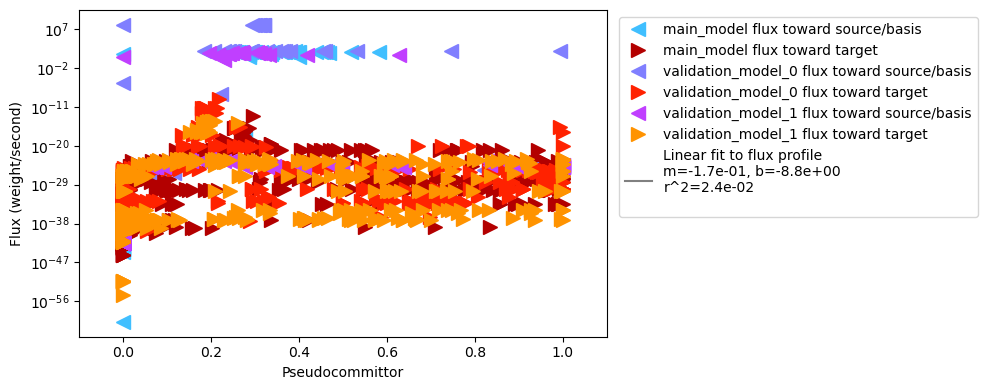

In [52]:
# plot again with cross validated model
model.plot_flux_committor()

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_4Dmap_postblockvalidation.pickle', 'rb') as f:
    model = load(f)

In [53]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_4Dmap_postblockvalidation.pickle', 'wb') as f:
    dump(model, f)

#### Block validation rates

In [54]:
for i in range(len(model.validation_models)):
    model.validation_models[i].get_steady_state_target_flux()

    print(f'Steady-state target rate is {model.validation_models[i].JtargetSS:.2e} for model {i}')

Steady-state target rate is 1.61e-18 for model 0
Steady-state target rate is 3.62e-26 for model 1


In [55]:
list_of_rates = [model.JtargetSS, model.validation_models[0].JtargetSS, model.validation_models[1].JtargetSS]
print(np.std(list_of_rates))
print(np.average(list_of_rates))

7.588829913656367e-19
5.366113275004001e-19


#### Quick aside: looking at the theory and code behind $k_{AB}$ calculation

Normalizing `model.fluxMatrix` to get transition matrix, output `model.Tmatrix`.
* row-normalize the flux matrix
* set any states with 0 flux (i.e. sinks) to have 1.0
* set target bins to uniformly recycle into basis bins

In [11]:
model.get_Tmatrix()

First calculate SS probability of microbins based on SS solution of the transition matrix (`model.pSS`). 

These are calculated as the eigenvectors of the transition matrix.

In [12]:
model.get_steady_state_algebraic()

[06/15/23 12:11:28] INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=623078;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=966892;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#237\237]8;;\
                             with matrix power method.                                                             

                    INFO     Corrected to semidefinite pSS in 176 iterations                       ]8;id=395661;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=933098;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#248\248]8;;\

Calculate sum of target state ss flux ($k_{AB}$) via https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045600/#FD3 equation 3:

$k_{AB} = Flux(A \rightarrow B;SS) = \sum_{i\notin B, j\in B} p_{i}^{\alpha}T_{ij}^{\alpha}$ (haMSM)

Here, $p^{\alpha}$ is given by `model.pSS` and $T^{\alpha}$ is given by `model.Tmatrix`.

Running `model.get_steady_state_target_flux()` calculates $k_{AB}$, output `model.JtargetSS`.

In [13]:
model.get_steady_state_target_flux()

In [14]:
model.JtargetSS

1.9954185219363416e-21

### Getting model outputs
---

Block validation output

In [ ]:
import weight_loop
for idx, v_model in enumerate(model.validation_models):
    if idx == 0:
        continue
    weight_loop.create_reweighted_h5_global(v_model,new_name=f'west_{idx}.h5')

Use haMSM weights to create new west.h5 file, use this updated west.h5 file for running subsequent WE simulations.

In [ ]:
import weight_loop

weight_loop.create_reweighted_h5_global(model, west_name='west_nocoords.h5', copy=True, 
                                        struct_filetype='ncrst', new_name=f'west_reweight.h5', 
                                        gen_sstates=True, pdb_out=False, link_out=True, 
                                        link_path="/ocean/projects/mcb180038p/jml230/bdpa_wsh2029_p3_r3",)

Extract transition state (pseudo-committor of a certain range)